Now that we have our data fully downloaded, we can ebgin the process of training our baseline RESNET34 model

Provided in the github are 3 tailored cv files that you must upload to compare our data against

Navigate to these files within the drive and load

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install fastai
!pip install pydicom
!pip install kornia

In [ ]:
from fastai.vision.all import *
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pydicom
import glob
import pandas as pd
import seaborn as sns
from fastai.medical.imaging import *

In [ ]:
%cd drive/MyDrive/
%ls

In [ ]:
fn = get_image_files('rsna-data/train_jpg/train_jpg/')
img = PILImage.create(fn[13], mode = 'L')
img

In [ ]:
len(fn)

194082

In [ ]:
labels = pd.read_csv('label.csv')
multi_labels = pd.read_csv('multi_labels.csv')
updated_multi_labels = pd.read_csv('updated_multi_labels.csv')

At this point we now have access to all the files within fn, and the corresponding data in labels, multi_labels, and updated_multi_label

In [ ]:
labels = labels.iloc[:,0:2]
labels.head()

,ID,any
0,ID_000039fa0,0
1,ID_00005679d,0
2,ID_00008ce3c,0
3,ID_0000950d7,0
4,ID_0000aee4b,0


In [ ]:
labels['ID'] = labels['ID'] + '.jpg'

In [ ]:
def show_batch(x, nrows = 5, ncols = 5, title = None):
    """
    Read a list of images, and display them
    """
    fig=plt.figure(figsize=(9, 9))
    if title: plt.title(title)
    for i in range(1, ncols*nrows +1):
        ds = x[i]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(ds, cmap=plt.cm.bone)
        fig.add_subplot

In [ ]:
%cd ..

/content/drive/MyDrive/rsna-data


We will filter the csvs to make sure we are only identifying the files that our found within our dataset

In [ ]:
file_list = os.listdir('train_jpg/train_jpg')

# Filter the DataFrame to include only files that exist in the directory
labels = labels[labels['ID'].isin(file_list)]

In [ ]:
dls_modified = ImageDataLoaders.from_df(labels, 'train_jpg/train_jpg/', bs = 32, seed = 42)

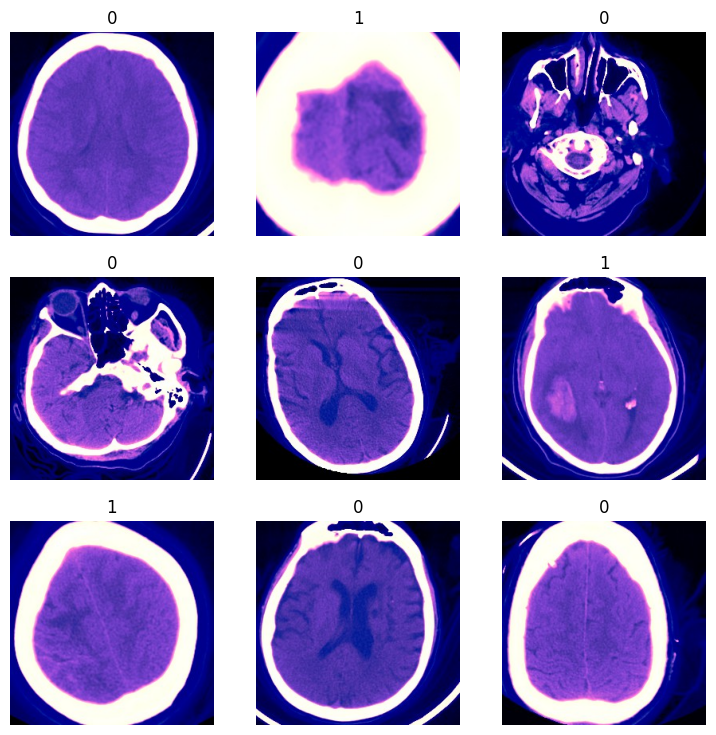

In [ ]:
dls_modified.show_batch()

We have finished prepping our non-label data and now we will move onto our multilabel data

In [ ]:
updated_multi_labels.columns

Index(['ID', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'multi'],
      dtype='object')

In [ ]:
updated_multi_labels = updated_multi_labels.drop(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], axis = 1)
updated_multi_labels.head()

,ID,multi
0,ID_000039fa0,NaN
1,ID_00005679d,NaN
2,ID_00008ce3c,NaN
3,ID_0000950d7,NaN
4,ID_0000aee4b,NaN


In [ ]:
tfms = L([FlipItem(p = 0.2)])

In [ ]:
updated_multi_labels['ID'] = updated_multi_labels['ID'] + '.jpg'

In [ ]:
file_list_multi = os.listdir('train_jpg/train_jpg')
# Filter the DataFrame to include only files that exist in the directory
updated_multi_labels = updated_multi_labels[updated_multi_labels['ID'].isin(file_list_multi)]

In [ ]:
display(updated_multi_labels)

,ID,multi
2,ID_00008ce3c.jpg,NaN
4,ID_0000aee4b.jpg,NaN
11,ID_0002003a8.jpg,NaN
12,ID_0002081b6.jpg,intraparenchymal
19,ID_00027cbb1.jpg,NaN
...,...,...
674236,ID_fffd8342d.jpg,NaN
674250,ID_ffff53123.jpg,NaN
674253,ID_ffff73ede.jpg,NaN
674254,ID_ffff80705.jpg,NaN


In [ ]:
updated_multi_labels = updated_multi_labels.dropna(subset=['multi'])

# Display the cleaned DataFrame
print("\nCleaned DataFrame:")
display(updated_multi_labels)


Cleaned DataFrame:


,ID,multi
12,ID_0002081b6.jpg,intraparenchymal
21,ID_0002a38ad.jpg,subarachnoid;subdural
28,ID_000346ce2.jpg,subdural
31,ID_00042829c.jpg,intraventricular
37,ID_0004a5701.jpg,subdural
...,...,...
674203,ID_fffb124e6.jpg,subarachnoid;subdural
674204,ID_fffb16e96.jpg,subdural
674217,ID_fffc60817.jpg,intraparenchymal;intraventricular
674229,ID_fffd00949.jpg,subarachnoid


In [ ]:
file_list_multi = os.listdir('train_jpg/train_jpg')
# Filter the DataFrame to include only files that exist in the directory
updated_multi_labels = updated_multi_labels[updated_multi_labels['ID'].isin(file_list_multi)]

In [ ]:
dls2 = ImageDataLoaders.from_df(updated_multi_labels, 'train_jpg/train_jpg', label_delim=';', batch_tfms=tfms, seed = 42)

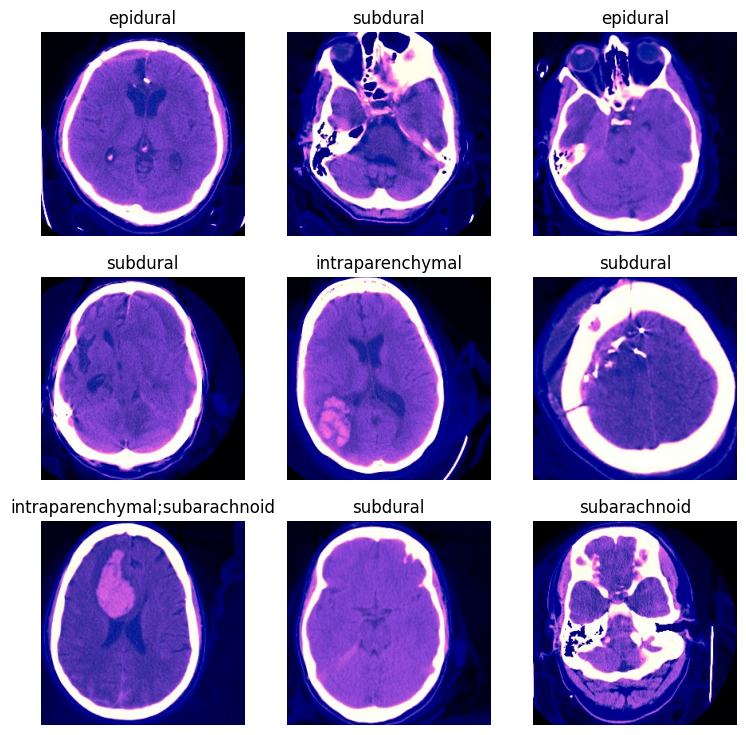

In [ ]:
dls2.show_batch()

We now have access to dls_modified and dls2, which contain the contains classification and the labeling respectively and we can begin to learn

The issue we face is that there is so much data that we will only train on a subset of the data

We will create a new folder with a subset of the data

In [ ]:
new_folder_name = 'batch'

# Create the new directory in the current working directory
new_folder_path = os.path.join(os.getcwd(), new_folder_name)
os.makedirs(new_folder_path, exist_ok=True)

In [ ]:
batch_items = fn[:1500]

In [ ]:
%cd ..

/content/drive/MyDrive


In [ ]:
for path in batch_items:
    if os.path.isfile(path):
        # It's a file, copy it
        shutil.copy(path, 'rsna-data/batch/')
    elif os.path.isdir(path):
        # It's a directory, copy the entire directory tree
        dest_dir = os.path.join(new_folder_path, os.path.basename(path))
        shutil.copytree(path, dest_dir)
    else:
        print(f"Error: {path} is not a file or directory")

print("Copying completed.")

Copying completed.


In [ ]:
%ls

batch/  batch2/  csvs/  cutmix/  meta/  train_jpg/


Lets chec that it copied properly

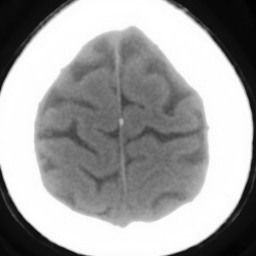

In [ ]:
fn_batch = get_image_files('batch/')
img = PILImage.create(fn_batch[13], mode = 'L')
img

In [ ]:
%cd ..

/content/drive/MyDrive/rsna-data


We now need to create new csvs to correspond with the shorter amount of data found within this new folder we created

In [ ]:
file_list_batch = os.listdir('batch/')
# Filter the DataFrame to include only files that exist in the directory
batch_multi_labels = updated_multi_labels[updated_multi_labels['ID'].isin(file_list_batch)]

In [ ]:
print(len(batch_multi_labels))

368


In [ ]:
#subdural_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('subdural')]
#display(subdural_data)

In [ ]:
#intraparenchymal_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('intraparenchymal')]
#display(intraparenchymal_data)

In [ ]:
#subarachnoid_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('subarachnoid')]
#display(subarachnoid_data)

In [ ]:
#intraventricular_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('intraventricular')]
#display(intraventricular_data)

In [ ]:
#epidural_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('epidural')]
#display(epidural_data)

In [ ]:
display(batch_multi_labels)

,ID,multi
32262,ID_0c3a90a5b.jpg,intraparenchymal
32266,ID_0c3b61e10.jpg,subdural
32275,ID_0c3c2e029.jpg,subarachnoid;subdural
32289,ID_0c3d7651d.jpg,intraparenchymal
32301,ID_0c3dfd95f.jpg,subarachnoid
...,...,...
35364,ID_0d6b174cf.jpg,subdural
35368,ID_0d6bbb7d4.jpg,subdural
35374,ID_0d6c0d346.jpg,subdural
35391,ID_0d6d4ba9f.jpg,intraventricular;subarachnoid;subdural


In [ ]:
tfms = L([FlipItem(p = 0.2)])

In [ ]:
dls_batch = ImageDataLoaders.from_df(batch_multi_labels, 'batch', label_delim=';', batch_tfms=tfms, seed = 42)

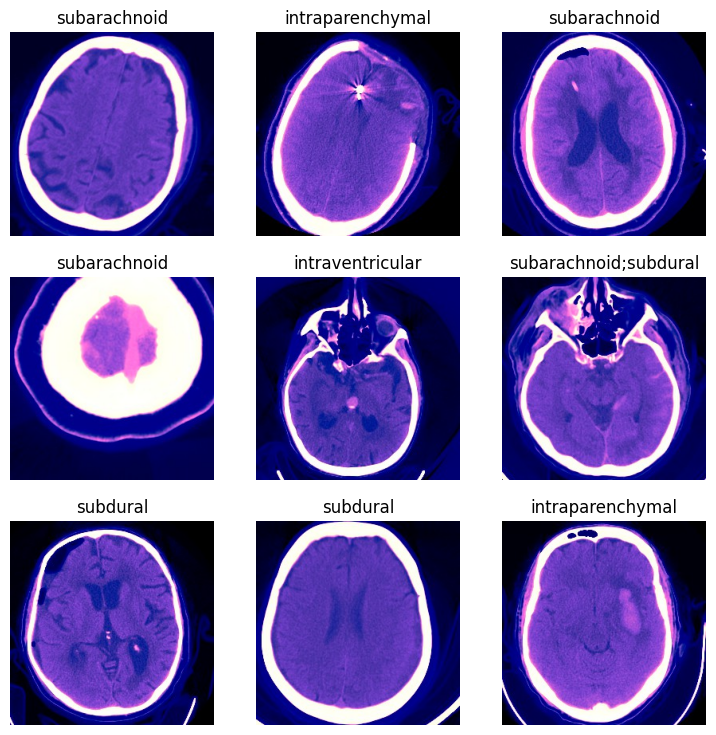

In [ ]:
dls_batch.show_batch()

Great! Now we have our subset of data, lets see of how much classifcation is in each

<ipython-input-27-c7c313e56b25>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=batch_label_counts.index, x=batch_label_counts.values, palette="deep",


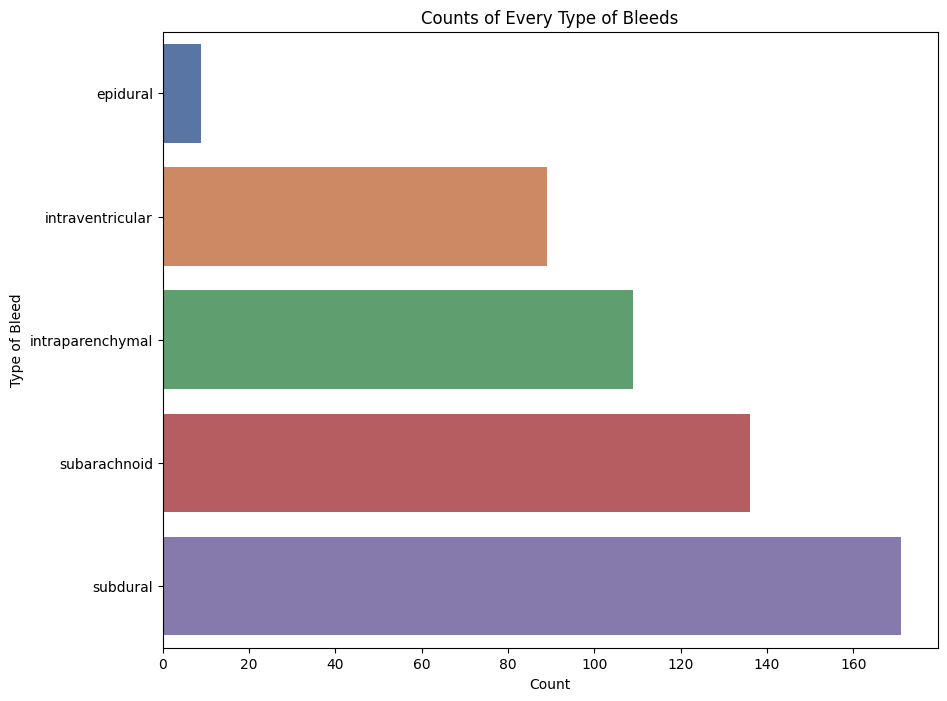

In [ ]:
batch_all_labels_indiv = batch_multi_labels['multi'].str.split(';').explode()

# Count each type of label
batch_label_counts = batch_all_labels_indiv.value_counts()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(y=batch_label_counts.index, x=batch_label_counts.values, palette="deep",
            order=batch_label_counts.index[::-1])  # This reverses the order
plt.title("Counts of Every Type of Bleeds")
plt.xlabel("Count")
plt.ylabel("Type of Bleed")
plt.show()


In [ ]:
len(dls_batch.train_ds),len(dls_batch.valid_ds),dls_batch.bs

(608, 152, 64)

We now will perform our machine learning using FastAI

We are strating with Resnet18 as our base model to see what we can improve upon

In [ ]:
learn_baseline = vision_learner(dls_batch, resnet18, metrics=accuracy_multi)

In [ ]:
learn_baseline.fit_one_cycle(2,0.004365158267319202)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.664726,0.739535,0.650000,05:29
1,0.575483,0.689729,0.676316,05:29
